# Implementation

## Import Pakages

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Audio, display

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch_geometric.nn import GCNConv, GATConv, Node2Vec, CorrectAndSmooth
from torch_geometric.utils import to_undirected, add_self_loops
from torch_geometric.transforms import ToSparseTensor 

from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

## Dataset

In [2]:
dataset_name = 'ogbn-arxiv'
dataset = PygNodePropPredDataset(name=dataset_name, root='data')
evaluator = Evaluator(name='ogbn-arxiv')
data = dataset[0]
print(data)

Downloaded 0.08 GB: 100%|██████████| 81/81 [00:54<00:00,  1.47it/s]


Extracting data\arxiv.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 937.69it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 358.67it/s]

Saving...


Data(num_nodes=169343, edge_index=[2, 1166243], x=[169343, 128], node_year=[169343, 1], y=[169343, 1])


Done!


## Data visualization

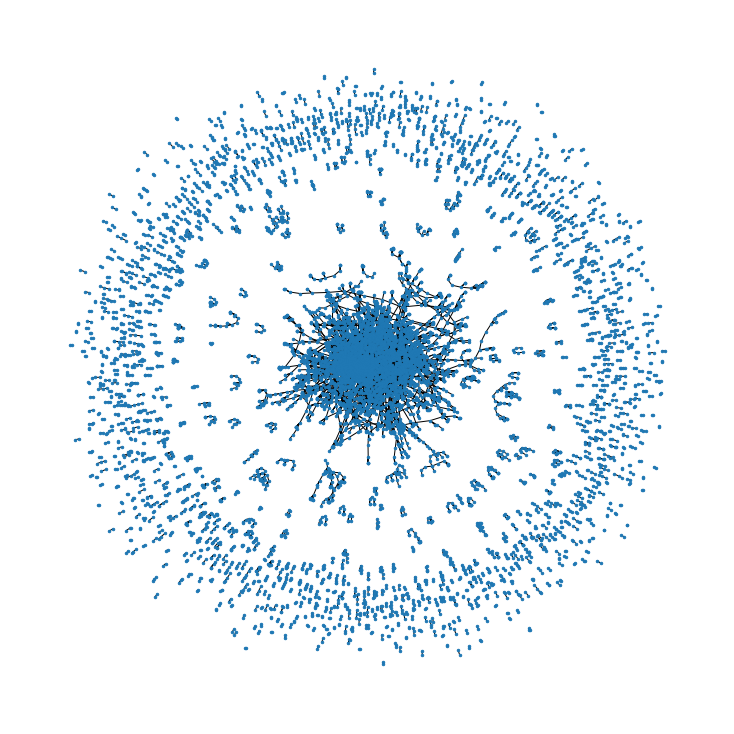

In [23]:
df_edge = pd.DataFrame()
df_edge['cited'] = data.edge_index[1, :]
df_edge['cite'] = data.edge_index[0, :]
slice = 10000
G = nx.from_pandas_edgelist(df_edge[:slice], source='cite', target='cited')
plt.figure(figsize=(10,10))
nx.draw(G, node_size=6)

## Initialization

In [ ]:
if torch.cuda.is_available():
    device ='cuda' 
#     device = 'cpu'
    print('Device: {}'.format(device), 
          '\nDevice count: {}'.format(torch.cuda.device_count()), 
          '\nDevice name: {}'.format(torch.cuda.get_device_name(0)))
else:
    device = 'cpu'
    print('Device: {}'.format(device))

split_idx = dataset.get_idx_split()
train_idx = split_idx['train'].to(device)
valid_idx = split_idx['valid'].to(device)
test_idx = split_idx['test'].to(device)
criterion = nn.NLLLoss().to(device)

Device: cuda 
Device count: 1 
Device name: NVIDIA GeForce RTX 3090


## Logger

In [6]:
class Logger(object):
    def __init__(self, runs, info=None):
        self.info = info
        self.results = [[] for _ in range(runs)]

    def add_result(self, run, result):
        assert len(result) == 3
        assert run >= 0 and run < len(self.results)
        self.results[run].append(result)

    def print_statistics(self, run=None, print_all=True):
        if run is not None:
            result = 100 * torch.tensor(self.results[run])
            argmax = result[:, 1].argmax().item()
            print(f'Run {run + 1:02d}:')
            print(f'Highest Train: {result[:, 0].max():.2f}')
            print(f'Highest Valid: {result[:, 1].max():.2f}')
            print(f'  Final Train: {result[argmax, 0]:.2f}')
            print(f'   Final Test: {result[argmax, 2]:.2f}')
        else:
            result = 100 * torch.tensor(self.results)

            best_results = []
            for r in result:
                train1 = r[:, 0].max().item()
                valid = r[:, 1].max().item()
                train2 = r[r[:, 1].argmax(), 0].item()
                test = r[r[:, 1].argmax(), 2].item()
                best_results.append((train1, valid, train2, test))

            best_result = torch.tensor(best_results)

            print(f'All runs:')
            if print_all:
                r = best_result[:, 0]
                print(f'Highest Train: {r.mean():.2f} ± {r.std():.2f}')
                r = best_result[:, 1]
                print(f'Highest Valid: {r.mean():.2f} ± {r.std():.2f}')
                r = best_result[:, 2]
                print(f'  Final Train: {r.mean():.2f} ± {r.std():.2f}')
            r = best_result[:, 3]
            print(f'   Final Test: {r.mean():.2f} ± {r.std():.2f}')

## Models

### GCN

In [7]:
class GCNNet(nn.Module):
    def __init__(self, in_dim, hidden=256, num_layers=3, dropout=0.5):
        """
        :param dataset: ogbn-arxiv dataset
        :param hidden: hidden layer, defult=256
        :param num_layers: number of layers, default=3
        """
        super(GCNNet, self).__init__()

        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.dropout = dropout

        self.convs.append(GCNConv(in_dim, hidden))
        self.bns.append(nn.BatchNorm1d(hidden))

        for i in range(self.num_layers - 2):
            self.convs.append(GCNConv(hidden, hidden))
            self.bns.append(nn.BatchNorm1d(hidden))

        self.convs.append(GCNConv(hidden, dataset.num_classes))

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):

        for i in range(self.num_layers - 1):
            x = self.convs[i](x, adj_t)
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.convs[-1](x, adj_t)
        x = F.log_softmax(x, dim=1)

        return x

### GAT

In [8]:
class GATNet(nn.Module):
    def __init__(self, in_dim, hidden=128, num_layers=3, heads=8, dropout=0.5):
        super(GATNet,self).__init__()
        
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        
        self.convs.append(GATConv(in_dim, hidden // heads, heads, dropout))
        self.bns.append(nn.BatchNorm1d(hidden))
        
        for _ in range(self.num_layers - 1):
            self.convs.append(GATConv(hidden, hidden // heads, heads, dropout))
            self.bns.append(nn.BatchNorm1d(hidden))
        
        self.convs.append(GATConv(hidden,  dataset.num_classes, 1, dropout))
        
    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()
    
    def forward(self, x, adj_t):
        
        for i in range(self.num_layers - 1):
            x = self.convs[i](x, adj_t)
            x = self.bns[i](x)
        x = self.convs[-1](x, adj_t)
        x =  F.log_softmax(x, dim=1)
        
        return x

### Residual_GCN

In [9]:
class GCN_res(nn.Module):
    def __init__(self, in_dim, hidden=256, num_layers=6, dropout=0.5):
        super(GCN_res, self).__init__()

        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.dropout = dropout
        
        # self.input_fc = nn.Linear(dataset.num_node_features, hidden)
        self.input_fc = nn.Linear(in_dim, hidden)

        for i in range(self.num_layers):
            self.convs.append(GCNConv(hidden, hidden))
            self.bns.append(nn.BatchNorm1d(hidden))

        self.out_fc = nn.Linear(hidden, dataset.num_classes)
        self.weights = torch.nn.Parameter(torch.randn((len(self.convs))))

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()
        self.input_fc.reset_parameters()
        self.out_fc.reset_parameters()
        torch.nn.init.normal_(self.weights)

    def forward(self, x, adj_t):

        x = self.input_fc(x)
        x_input = x

        layer_out = []
        for i in range(self.num_layers):
            x = self.convs[i](x, adj_t)
            x = self.bns[i](x)
            x = F.relu(x, inplace=True)
            x = F.dropout(x, p=self.dropout, training=self.training)

            if i == 0:
                x = x + 0.2 * x_input
            else:
                x = x + 0.2 * x_input + 0.5 * layer_out[i - 1]
            layer_out.append(x)

        weight = F.softmax(self.weights, dim=0)
        for i in range(len(layer_out)):
            layer_out[i] = layer_out[i] * weight[i]

        x = sum(layer_out)
        x = self.out_fc(x)
        x = F.log_softmax(x, dim=1)

        return x

### Residual_GAT

In [10]:
class GAT_res(nn.Module):
    def __init__(self, in_dim, hidden=128, num_layers=6, heads=8, dropout=0.5):
        super(GAT_res, self).__init__()

        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.dropout = dropout
        
        # self.input_fc = nn.Linear(dataset.num_node_features, hidden)
        self.input_fc = nn.Linear(in_dim, hidden)

        for i in range(self.num_layers):
            self.convs.append(GATConv(hidden, hidden // heads, heads, dropout))
            self.bns.append(nn.BatchNorm1d(hidden))

        self.out_fc = nn.Linear(hidden, dataset.num_classes)
        self.weights = torch.nn.Parameter(torch.randn((len(self.convs))))

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()
        self.input_fc.reset_parameters()
        self.out_fc.reset_parameters()
        torch.nn.init.normal_(self.weights)

    def forward(self, x, adj_t):

        x = self.input_fc(x)
        x_input = x

        layer_out = []
        for i in range(self.num_layers):
            x = self.convs[i](x, adj_t)
            x = self.bns[i](x)
            x = F.relu(x, inplace=True)
            x = F.dropout(x, p=self.dropout, training=self.training)

            if i == 0:
                x = x + 0.2 * x_input
            else:
                x = x + 0.2 * x_input + 0.5 * layer_out[i - 1]
            layer_out.append(x)

        weight = F.softmax(self.weights, dim=0)
        for i in range(len(layer_out)):
            layer_out[i] = layer_out[i] * weight[i]

        x = sum(layer_out)
        x = self.out_fc(x)
        x = F.log_softmax(x, dim=1)

        return x

## Functions

### Alarm

In [11]:
def allDone():
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

### Data Preprocess

In [ ]:
# Add Self Loops
def preprocess(data, args):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    edge_index = data.edge_index.to(device)
    edge_index = to_undirected(edge_index, data.num_nodes)
    print(f'Total edges before adding self-loop {edge_index.count_nonzero()}', flush=True)
    edge_index = add_self_loops(edge_index, num_nodes=data.num_nodes)[0]
    print(f'Total edges after adding self-loop {edge_index.count_nonzero()}', flush=True)
    data.edge_index = edge_index

    # Node2Vec Embedding
    if args['use_embed']:
        feat = data.x
        embedding = torch.load(f"arxiv_embedding_{args['embedding_dim'], args['walk_length'], args['context_size'], args['walks_per_node'], args['batch_size']}.pt", map_location=device)
        data.x = torch.cat([feat, embedding], dim=-1)
        print(f'Finished embedding.', flush=True)

    return data

### Node2Vec

In [1]:
def save_embedding(model, args):
    torch.save(model.embedding.weight.data.cpu(), 
               f"arxiv_embedding_{args['embedding_dim'], args['walk_length'], args['context_size'], args['walks_per_node'], args['batch_size']}.pt")


def embedding(args):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)
    model = Node2Vec(data.edge_index, args['embedding_dim'], args['walk_length'],
                     args['context_size'], args['walks_per_node'],
                     sparse=True).to(device)
    loader = model.loader(batch_size=args['batch_size'], shuffle=True,
                          num_workers=0)
    optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=args['n2v_lr'])

    model.train()
    for epoch in range(1, args['n2v_epochs'] + 1):
        for i, (pos_rw, neg_rw) in enumerate(loader):
            optimizer.zero_grad()
            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            optimizer.step()

            if (i + 1) % args['log_steps'] == 0:
                print(f'Epoch: {epoch:02d}, Step: {i+1:03d}/{len(loader)}, '
                      f'Loss: {loss:.4f}')

            if (i + 1) % 100 == 0:  # Save model every 100 steps.
                save_embedding(model, args)
        save_embedding(model, args)

### Main

In [12]:
def add_labels(feat, labels, idx):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    onehot = torch.zeros([feat.shape[0], dataset.num_classes]).to(device)
    onehot[idx, labels[idx, 0]] = 1
    return torch.cat([feat, onehot], dim=-1)


def train(args):
    model.train()
    
    feat = data.x
    if args['use_labels']:
        mask = torch.rand(train_idx.shape) < args['mask_rate']
        
        train_labels_idx = train_idx[mask]
        train_pred_idx = train_idx[~mask]
        feat = add_labels(feat, data.y, train_labels_idx)
    else:
        train_pred_idx = train_idx
        
    optimizer.zero_grad()
    out = model(feat, data.adj_t)
    
    if args['use_labels'] and args['n_label_iters'] > 0:
        unlabel_idx = torch.cat([train_pred_idx, valid_idx, test_idx])
        for _ in range(args['n_label_iters']):
            out = out.detach()
            torch.cuda.empty_cache()
            feat[unlabel_idx, -dataset.num_classes:] = F.softmax(out[unlabel_idx], dim=-1)
            out = model(feat, data.adj_t)
            
    loss = criterion(out[train_pred_idx], data.y.squeeze(1)[train_pred_idx])
    loss.backward()
    optimizer.step()

    return loss.item()


@torch.no_grad()
def test(args, out=None):
    model.eval()
    
    feat = data.x

    if args['use_labels']:
        feat = add_labels(feat, data.y, train_idx)
        
    out = model(feat, data.adj_t) if out is None else out
    y_pred = out.argmax(dim=-1, keepdim=True)
    
    if args['use_labels'] and args['n_label_iters'] > 0:
        unlabel_idx = torch.cat([valid_idx, test_idx])
        for _ in range(args['n_label_iters']):
            feat[unlabel_idx, -dataset.num_classes:] = F.softmax(out[unlabel_idx], dim=-1)

            out = model(feat, data.adj_t) if out is None else out
            y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, valid_acc, test_acc, out

transform = ToSparseTensor()

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def run(args):
    runs = args['runs']
    logger = Logger(runs)
    
    for run in range(runs):
        print('#Params:', sum(p.numel() for p in model.parameters()))
        model.reset_parameters()
        
        best_valid_acc = 0

        for epoch in range(args['epochs']):
            loss = train(args)
            result = test(args)
            train_acc, valid_acc, test_acc, out = result
                
            print(f'Run: {run + 1:02d}, '
                  f'Epoch: {epoch:02d}, '
                  f'Loss: {loss:.4f}, '
                  f'Train: {100 * train_acc:.2f}%, '
                  f'Valid: {100 * valid_acc:.2f}% '
                  f'Test: {100 * test_acc:.2f}%')
            
            if args['C&S']:
                if valid_acc > best_valid_acc:
                    best_valid_acc = valid_acc
                    y_soft = out.softmax(dim=-1)
            else:
                result = (train_acc, valid_acc, test_acc)
                logger.add_result(run, result)
                
        if args['C&S']:
            adj_t = data.adj_t.to(device)
            deg = adj_t.sum(dim=1).to(torch.float)
            deg_inv_sqrt = deg.pow_(-0.5)
            deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
            DAD = deg_inv_sqrt.view(-1, 1) * adj_t * deg_inv_sqrt.view(1, -1)
            # DA = deg_inv_sqrt.view(-1, 1) * deg_inv_sqrt.view(-1, 1) * adj_t
            
            post = CorrectAndSmooth(num_correction_layers=args['num_correction_layers'], correction_alpha=args['correction_alpha'],
                                    num_smoothing_layers=args['num_smoothing_layer'], smoothing_alpha=args['smoothing_alpha'],
                                    autoscale=args['autoscale'], scale=args['scale'])
            
            if not args['only_smooth']:
                print('Correct and smooth...')
                y_soft = post.correct(y_soft, data.y[train_idx], train_idx, DAD)
            else:
                print('Only smooth...')
            y_soft = post.smooth(y_soft, data.y[train_idx], train_idx, DAD)
            print('Done!')
            train_acc, valid_acc, test_acc, _ = test(args, y_soft)
            print(f'Train: {train_acc:.4f}, Valid: {valid_acc:.4f}, Test: {test_acc:.4f}')
            
            result = (train_acc, valid_acc, test_acc)
            logger.add_result(run, result)

    logger.print_statistics()
    allDone()

# Results

## GCN

### GCN

In [ ]:
args={
    'runs': 2,
    'epochs': 500,
    'hidden_dim': 128,
    'num_layers': 8,
    'dropout': 0.5,
    'heads': 8,
    'lr':0.01,
    
    # Label_Reuse Params
    'use_labels': False,
    # 'mask_rate': 0.5,
    # 'n_label_iters': 1,
    
    # Correct&Smooth Params
    'C&S': False,
}

data = dataset[0]
data = data.to(device)

data = transform(data)
data.adj_t = data.adj_t.to_symmetric()

input_features = dataset.num_node_features

model = GCNNet(in_dim=input_features,
               hidden=args['hidden_dim'], 
               num_layers=args['num_layers'], 
               dropout=args['dropout'])

print(f'Model:\n{model}')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=args['lr'])

run(args)

### Residual_GCN

In [ ]:
args={
    'runs': 10,
    'epochs': 500,
    'hidden_dim': 128,
    'num_layers': 8,
    'dropout': 0.5,
    'heads': 8,
    'lr':0.01,
    
    # Label_Reuse Params
    'use_labels': False,
    # 'mask_rate': 0.5,
    # 'n_label_iters': 1,
    
    # Correct&Smooth Params
    'C&S': False,
}

data = dataset[0]
data = data.to(device)

data = transform(data)
data.adj_t = data.adj_t.to_symmetric()

input_features = dataset.num_node_features

model = GCN_res(in_dim=input_features,
                hidden=args['hidden_dim'], 
                num_layers=args['num_layers'],
                dropout=args['dropout'])

print(f'Model:\n{model}')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=args['lr'])

run(args)

### Residual_GCN+Node2Vec

In [ ]:
args={
    'runs': 10,
    'epochs': 500,
    'hidden_dim': 128,
    'num_layers': 5,
    'dropout': 0.5,
    'heads': 8,
    'lr':0.01,
    
    # Node2Vec Params
    'preprocess': True,
    'embedding_dim': 128,
    'walk_length': 80,
    'context_size': 20,
    'walks_per_node': 10,
    'batch_size': 128,
    'n2v_lr': 0.01,
    'n2v_epochs': 5,
    'log_steps': 1,
    'use_embed': True,
    
    # Label_Reuse Params
    'use_labels': False,
    # 'mask_rate': 0.5,
    # 'n_label_iters': 1,
    
    # Correct&Smooth Params
    'C&S': False,
}

data = dataset[0]
data = data.to(device)
input_features = dataset.num_node_features

# Node2Vec Preprocess
if args['preprocess']:
    if args['use_embed']:
        if not os.path.exists(f"arxiv_embedding_{args['embedding_dim'], args['walk_length'], args['context_size'], args['walks_per_node'], args['batch_size']}.pt"):
            print('start training node2vec embedding.')
            embedding(args)
        input_features += args['embedding_dim']
        
    data = preprocess(data, args)

data = transform(data)
data.adj_t = data.adj_t.to_symmetric()

model = GAT_res(in_dim=input_features,
                hidden=args['hidden_dim'], 
                num_layers=args['num_layers'],
                heads=args['heads'],
                dropout=args['dropout'])
print(f'Model:\n{model}')

model.to(device)
optimizer = optim.Adam(model.parameters(), lr=args['lr'])

run(args)

### Residual_GAT+Node2Vec+Label_Reuse

In [ ]:
args={
    'runs': 10,
    'epochs': 500,
    'hidden_dim': 128,
    'num_layers': 8,
    'dropout': 0.5,
    'heads': 8,
    'lr':0.01,
    
    # Node2Vec Params
    'preprocess': True,
    'embedding_dim': 128,
    'walk_length': 80,
    'context_size': 20,
    'walks_per_node': 10,
    'batch_size': 128,
    'n2v_lr': 0.01,
    'n2v_epochs': 5,
    'log_steps': 1,
    'use_embed': True,
    
    # Label_Reuse Params
    'use_labels': True,
    'mask_rate': 0.5,
    'n_label_iters': 1,
    
    # Correct&Smooth Params
    'C&S': False,
}

data = dataset[0]
data = data.to(device)
input_features = dataset.num_node_features

# Node2Vec Preprocess
if args['preprocess']:
    if args['use_embed']:
        if not os.path.exists(f"arxiv_embedding_{args['embedding_dim'], args['walk_length'], args['context_size'], args['walks_per_node'], args['batch_size']}.pt"):
            print('start training node2vec embedding.')
            embedding(args)
        input_features += args['embedding_dim']
        
    data = preprocess(data, args)
    print(input_features, data.x.shape)

data = transform(data)
data.adj_t = data.adj_t.to_symmetric()

# Label Reuse
if args['use_labels']:
    input_features += dataset.num_classes
    
model = GCN_res(in_dim=input_features,
                hidden=args['hidden_dim'], 
                num_layers=args['num_layers'],
                dropout=args['dropout'])
print(f'Model:\n{model}')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=args['lr'])

run(args)

### Residual_GAT+C&S

In [ ]:
args={
    'runs': 10,
    'epochs': 500,
    'hidden_dim': 128,
    'num_layers': 5,
    'dropout': 0.5,
    'heads': 8,
    'lr':0.01,
    
    # Label_Reuse Params
    'use_labels': False,
    # 'mask_rate': 0.5,
    # 'n_label_iters': 1,
    
    # Correct&Smooth Params
    'C&S': True,
    'only_smooth': False,
    'num_correction_layers': 50,
    'correction_alpha': 0.7,
    'num_smoothing_layer': 50,
    'smoothing_alpha': 0.7,
    'autoscale': False,
    'scale': 1.0,
}

data = dataset[0]
data = data.to(device)

data = transform(data)
data.adj_t = data.adj_t.to_symmetric()

input_features = dataset.num_node_features

model = GAT_res(in_dim=input_features,
                hidden=args['hidden_dim'], 
                num_layers=args['num_layers'],
                heads=args['heads'],
                dropout=args['dropout'])

print(f'Model:\n{model}')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=args['lr'])

run(args)

### Residual_GAT+Node2Vec+Label_Reuse+C&S

In [ ]:
args={
    'runs': 10,
    'epochs': 500,
    'hidden_dim': 128,
    'num_layers': 8,
    'dropout': 0.5,
    'heads': 8,
    'lr':0.01,
    
    # Node2Vec Params
    'preprocess': True,
    'embedding_dim': 128,
    'walk_length': 80,
    'context_size': 20,
    'walks_per_node': 10,
    'batch_size': 128,
    'n2v_lr': 0.01,
    'n2v_epochs': 5,
    'log_steps': 1,
    'use_embed': True,
    
    # Label_Reuse Params
    'use_labels': True,
    'mask_rate': 0.5,
    'n_label_iters': 1,
    
    # Correct&Smooth Params
    'C&S': True,
    'only_smooth': False,
    'num_correction_layers': 50,
    'correction_alpha': 0.7,
    'num_smoothing_layer': 50,
    'smoothing_alpha': 0.7,
    'autoscale': False,
    'scale': 1.0,
}

data = dataset[0]
data = data.to(device)
input_features = dataset.num_node_features

# Node2Vec Preprocess
if args['preprocess']:
    if args['use_embed']:
        if not os.path.exists(f"arxiv_embedding_{args['embedding_dim'], args['walk_length'], args['context_size'], args['walks_per_node'], args['batch_size']}.pt"):
            print('start training node2vec embedding.')
            embedding(args)
        input_features += args['embedding_dim']
        
    data = preprocess(data, args)

data = transform(data)
data.adj_t = data.adj_t.to_symmetric()

# Label Reuse
if args['use_labels']:
    input_features += dataset.num_classes
    
model = GCN_res(in_dim=input_features,
                hidden=args['hidden_dim'], 
                num_layers=args['num_layers'],
                dropout=args['dropout'])
print(f'Model:\n{model}')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=args['lr'])

run(args)

## GAT

### GAT

In [ ]:
args={
    'runs': 2,
    'epochs': 500,
    'hidden_dim': 128,
    'num_layers': 3,
    'dropout': 0.5,
    'heads': 8,
    'lr':0.01,
    
    # Label_Reuse Params
    'use_labels': False,
    # 'mask_rate': 0.5,
    # 'n_label_iters': 1,
    
    # Correct&Smooth Params
    'C&S': False,
}

data = dataset[0]
data = data.to(device)

data = transform(data)
data.adj_t = data.adj_t.to_symmetric()

input_features = dataset.num_node_features

model = GATNet(in_dim=input_features,
               hidden=args['hidden_dim'], 
               num_layers=args['num_layers'],
               heads=args['heads'],
               dropout=args['dropout'])

print(f'Model:\n{model}')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=args['lr'])

run(args)

### Residual_GAT

In [ ]:
args={
    'runs': 10,
    'epochs': 500,
    'hidden_dim': 128,
    'num_layers': 5,
    'dropout': 0.5,
    'heads': 8,
    'lr':0.01,
    
    # Label_Reuse Params
    'use_labels': False,
    # 'mask_rate': 0.5,
    # 'n_label_iters': 1,
    
    # Correct&Smooth Params
    'C&S': False,
}

data = dataset[0]
data = data.to(device)

data = transform(data)
data.adj_t = data.adj_t.to_symmetric()

input_features = dataset.num_node_features

model = GAT_res(in_dim=input_features,
                num_layers=args['num_layers'],
                heads=args['heads'],
                dropout=args['dropout'])

print(f'Model:\n{model}')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=args['lr'])
    
run(args)

### Residual_GAT+Node2Vec

In [ ]:
args={
    'runs': 10,
    'epochs': 500,
    'hidden_dim': 128,
    'num_layers': 5,
    'dropout': 0.5,
    'heads': 8,
    'lr':0.01,
    
    # Node2Vec Params
    'preprocess': True,
    'embedding_dim': 128,
    'walk_length': 80,
    'context_size': 20,
    'walks_per_node': 10,
    'batch_size': 128,
    'n2v_lr': 0.01,
    'n2v_epochs': 5,
    'log_steps': 1,
    'use_embed': True,
    
    # Label_Reuse Params
    'use_labels': False,
    # 'mask_rate': 0.5,
    # 'n_label_iters': 1,
    
    # Correct&Smooth Params
    'C&S': False,
}

data = dataset[0]
data = data.to(device)
input_features = dataset.num_node_features

# Node2Vec Preprocess
if args['preprocess']:
    if args['use_embed']:
        if not os.path.exists(f"arxiv_embedding_{args['embedding_dim'], args['walk_length'], args['context_size'], args['walks_per_node'], args['batch_size']}.pt"):
            print('start training node2vec embedding.')
            embedding(args)
        input_features += args['embedding_dim']
        
    data = preprocess(data, args)

data = transform(data)
data.adj_t = data.adj_t.to_symmetric()

model = GAT_res(in_dim=input_features,
                hidden=args['hidden_dim'], 
                num_layers=args['num_layers'],
                heads=args['heads'],
                dropout=args['dropout'])
print(f'Model:\n{model}')

model.to(device)
optimizer = optim.Adam(model.parameters(), lr=args['lr'])

run(args)

### Residual_GAT+Node2Vec+Label_Reuse

In [ ]:
args={
    'runs': 10,
    'epochs': 500,
    'hidden_dim': 128,
    'num_layers': 5,
    'dropout': 0.5,
    'heads': 8,
    'lr':0.01,
    
    # Node2Vec Params
    'preprocess': True,
    'embedding_dim': 128,
    'walk_length': 80,
    'context_size': 20,
    'walks_per_node': 10,
    'batch_size': 128,
    'n2v_lr': 0.01,
    'n2v_epochs': 5,
    'log_steps': 1,
    'use_embed': True,
    
    # Label_Reuse Params
    'use_labels': True,
    'mask_rate': 0.5,
    'n_label_iters': 1,
    
    # Correct&Smooth Params
    'C&S': False,
}

data = dataset[0]
data = data.to(device)
input_features = dataset.num_node_features

# Node2Vec Preprocess
if args['preprocess']:
    if args['use_embed']:
        if not os.path.exists(f"arxiv_embedding_{args['embedding_dim'], args['walk_length'], args['context_size'], args['walks_per_node'], args['batch_size']}.pt"):
            print('start training node2vec embedding.')
            embedding(args)
        input_features += args['embedding_dim']
        
    data = preprocess(data, args)
    print(input_features, data.x.shape)

data = transform(data)
data.adj_t = data.adj_t.to_symmetric()

# Label Reuse
if args['use_labels']:
    input_features += dataset.num_classes
    
model = GAT_res(in_dim=input_features,
                hidden=args['hidden_dim'], 
                num_layers=args['num_layers'],
                heads=args['heads'],
                dropout=args['dropout'])
print(f'Model:\n{model}')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=args['lr'])

run(args)

### Residual_GAT+C&S

In [ ]:
args={
    'runs': 10,
    'epochs': 500,
    'hidden_dim': 128,
    'num_layers': 5,
    'dropout': 0.5,
    'heads': 8,
    'lr':0.01,
    
    # Label_Reuse Params
    'use_labels': False,
    # 'mask_rate': 0.5,
    # 'n_label_iters': 1,
    
    # Correct&Smooth Params
    'C&S': True,
    'only_smooth': False,
    'num_correction_layers': 50,
    'correction_alpha': 0.7,
    'num_smoothing_layer': 50,
    'smoothing_alpha': 0.7,
    'autoscale': False,
    'scale': 1.0,
}

data = dataset[0]
data = data.to(device)

data = transform(data)
data.adj_t = data.adj_t.to_symmetric()

input_features = dataset.num_node_features

model = GAT_res(in_dim=input_features,
                hidden=args['hidden_dim'], 
                num_layers=args['num_layers'],
                heads=args['heads'],
                dropout=args['dropout'])

print(f'Model:\n{model}')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=args['lr'])

run(args)

### Residual_GAT+Node2Vec+Label_Reuse+C&S

In [ ]:
args={
    'runs': 10,
    'epochs': 500,
    'hidden_dim': 128,
    'num_layers': 5,
    'dropout': 0.5,
    'heads': 8,
    'lr':0.01,
    
    # Node2Vec Params
    'preprocess': True,
    'embedding_dim': 128,
    'walk_length': 80,
    'context_size': 20,
    'walks_per_node': 10,
    'batch_size': 128,
    'n2v_lr': 0.01,
    'n2v_epochs': 5,
    'log_steps': 1,
    'use_embed': True,
    
    # Label_Reuse Params
    'use_labels': True,
    'mask_rate': 0.5,
    'n_label_iters': 1,
    
    # Correct&Smooth Params
    'C&S': True,
    'only_smooth': False,
    'num_correction_layers': 50,
    'correction_alpha': 0.7,
    'num_smoothing_layer': 50,
    'smoothing_alpha': 0.7,
    'autoscale': False,
    'scale': 1.0,
}

data = dataset[0]
data = data.to(device)
input_features = dataset.num_node_features

# Node2Vec Preprocess
if args['preprocess']:
    if args['use_embed']:
        if not os.path.exists(f"arxiv_embedding_{args['embedding_dim'], args['walk_length'], args['context_size'], args['walks_per_node'], args['batch_size']}.pt"):
            print('start training node2vec embedding.')
            embedding(args)
        input_features += args['embedding_dim']
        
    data = preprocess(data, args)
    print(input_features, data.x.shape)

data = transform(data)
data.adj_t = data.adj_t.to_symmetric()

# Label Reuse
if args['use_labels']:
    input_features += dataset.num_classes

model = GAT_res(in_dim=input_features,
                hidden=args['hidden_dim'], 
                num_layers=args['num_layers'],
                heads=args['heads'],
                dropout=args['dropout'])
print(f'Model:\n{model}')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=args['lr'])

run(args)

# End

In [ ]:
# save environment and shut down
# time.sleep(60)
# !export $(cat /proc/1/environ |tr '\0' '\n' | grep MATCLOUD_CANCELTOKEN)&&/public/script/matncli node cancel -url https://matpool.com/api/public/node -save -name Completed